# Gaussian Processes Implementaiton

In [1]:
import scipy.io
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error as mse

### RBF kernel

The RBF kernel is a stationary kernel. It is also known as the “squared exponential” kernel. It is parameterized by a length-scale parameter $l$ which control the smoothness along the feature dimentions and $sigma_f$ which controls the amplitude of the kernel. The kernel is given by:

\begin{align}
k(x_i, x_j) = \sigma_f^2 exp\bigg(- \frac{(x_i - x_j)^T(x_i - x_j)}{2l^2}\bigg)
\end{align}

In [2]:
class RBF_kernel:
    """
    Creates an object of radial basis function (exponential) kernel

    Methods
    -------
    calculate(X1, X2)
        Calculate value of the kernel
    """

    def __init__(self, parameters=None, dimension=None, bounds=None):
        """
        Parameters
        ----------
        parameters : list
            Hyperparameters of the kernel
        dimension : int
            Number of hyperparameters' dimensions. Used in training to select number of length scale hyperparameters
        bounds : list
            Bounds for hyperparameters tuning
        """
        if dimension:
            # In training, number of hyperparameters is specified
            # needed self._ for change in @property
            self._sigma_f = 1  # Amplitude hyperparameter (initial value)
            self._length = []  # Characteristic lenght scale hyperparameter
            self._bounds = [(1e-6, 1e6)]  # Additional bound is for sigma_f
            for i in range(dimension):
                self._length.append(1)
                self._bounds.append((1e-6, 1e6))
            self._parameters = [self._length, self._sigma_f]
        # When parameters are given, for instance, already found
        # from previous training, object is initialized using them
        elif parameters is not None:
            self._parameters = parameters
            # Amplitude is specified as last hyperparameter
            self._sigma_f = self._parameters[-1]
            self._length = self._parameters[:-1]
            self._bounds = bounds
        else:
            raise ("Specify the lengths scale parameter and bounds "
                   "or dimensions of the feature space, In the latter,"
                   "default values will be used")

    def calculate(self, X1, X2):
        """
        Computes values of kernel given hyperparameters
        Parameters
        ----------
        X1 : array  
            array of th features
        X2 : array
            array of th features
        Returns
        -------
        kernel : float
            value of the kernel function
        """
        K_mat = {}  # Dictionary with matricies of covariances
        for i in range(X1.shape[1]):  # for each feature in the dataset
            K_mat["K" + str(i)] = 1 / (2 * (self._length[i] ** 2)) \
                                  * (X1[:, i].reshape(-1, 1) - X2[:, i].T) \
                                  * (X1[:, i].reshape(-1, 1) - X2[:, i].T)
        # Initialize power of the exponent
        exp_power = np.zeros(shape=(K_mat["K0"].shape[0],
                                    K_mat["K0"].shape[1]))
        for matrix in K_mat:
            exp_power = exp_power + K_mat[matrix]
        # Compute kernel value
        kernel = self._sigma_f * np.exp(-exp_power)
        return kernel

    @property
    def parameters(self):
        """Returns a list of hyperparameters"""
        from itertools import chain
        params = list(chain.from_iterable(
            i if isinstance(i, list)
            else [i] for i in self._parameters))  # Unlist unnecessary nested list
        return params

    @parameters.setter
    def parameters(self, value):
        """Sets hyperparameters to its values"""
        self._parameters = value
        self._sigma_f = self._parameters[-1]
        self._length = self._parameters[:-1]

    @property
    def parameter_bounds(self):
        """Returns hyperparameters' bounds"""
        return self._bounds

### Neural network kernel

We can obtain a covariance function of a neural network by evaluating $E_u[h(x;u)h(x';u)]$ where h(x;u) - the hidden unit transfer function. The neural network covariance becomes:

\begin{align}
k(x_i, x_j) = \frac{2}{\pi} sin-1\bigg(- \frac{2 x_i^T \sum x_j}{\sqrt{(1 + 2 x_i^T \sum x_j)(1 + 2 x_i^T \sum x_j)}}\bigg)
\end{align}

In [3]:
class NN_kernel:
    """
    Creates an object of a neural network kernel
        Attributes
    ----------
    parameters: list
        Hyperparameters of the kernel
    dimensions: int
        Number of hyperparameters' dimensions. Used in training in
        order to select number of length scale hyperparameters
    bounds: list
        Bounds for hyperparameters tuning

    Methods
    -------
    calculate(X1, X2)
        Calculate value of the kernel
    """

    def __init__(self, dimension=None, init_amplitude=0.1, parameters=None, bounds=None):
        """
        Parameters
        ----------
        parameters: list
            Hyperparameters of the kernel
        dimensions: int
            Number of hyperparameters' dimensions. Used in training  to select number of length scale hyperparameters
        bounds: list
            Bounds for hyperparameters tuning dimension
        init_amplitude : float
            initial assumption of the amplitude value
        """
        # In training, number of hyperparameters is specified
        # needed self._ for change in @property
        if dimension:
            self._sigmas = init_amplitude * np.ones(shape=(1, dimension + 1))
            self._bounds = []
            for i in range(dimension + 1):
                self._bounds.append((1e-1, 0.5))
            self._parameters = self._sigmas
        # When parameters are given, for instance, already found
        # from previous training, object is initialized using them
        elif parameters is not None:
            self._sigmas = np.array(parameters).reshape(1, -1)
            self._bounds = bounds
            self._parameters = self._sigmas

    def calculate(self, X1, X2):
        """
        Computes values of kernel given hyperparameters
        Parameters
        ----------
        X1 : array
            array of th features
        X2 : array
            array of th features
        Returns
        -------
        kernel : float
            value of the kernel function
        """
        covariance = np.zeros(shape=(self._sigmas.shape[1],
                                     self._sigmas.shape[1]))
        for i in range(X1.shape[1] + 1):
            covariance[i, i] = self._sigmas[0, i]

        X1 = np.concatenate((np.ones(shape=(X1.shape[0], 1)), X1), axis=1)
        X2 = np.concatenate((np.ones(shape=(X2.shape[0], 1)), X2), axis=1)
        numenator = 2 * np.dot(X1, np.dot(covariance, X2.T))
        denumenator_1 = 1 + 2 * (np.einsum('ij,ij->i', X1,
                                           np.dot(covariance, X1.T).T).reshape(-1, 1)
                                 * np.ones(shape=(1, X2.shape[0])))
        denumenator_2 = 1 + 2 * (np.einsum('ij,ij->i', X2,
                                           np.dot(covariance, X2.T).T).reshape(1, -1)
                                 * np.ones(shape=(X1.shape[0], 1)))
        # Clip because the values can be outside (-1, 1)
        arg = np.clip(numenator / (np.sqrt(denumenator_1, denumenator_2)), -1, 1)
        # Compute kernel values
        kernel = 2 / np.pi * np.arcsin(arg)

        return kernel

    @property
    def parameters(self):
        """Returns a list of hyperparameters"""
        from itertools import chain
        params = list(chain.from_iterable(
            i if isinstance(i, list)
            else [i] for i in self._parameters.tolist()))  # Unlist nested lists
        return params

    @parameters.setter
    def parameters(self, value):
        """Sets hyperparameters to its values"""
        self._parameters = value
        self._sigmas = np.array(self._parameters).reshape(1, -1)

    @property
    def parameter_bounds(self):
        """
        Returns a list of bounds of the kernel parameters
        """
        return self._bounds

# Kernel sum

In order to represent complex data dependencies, we will need to sum several kernels and fit hyperparameters of each kernel. As such, we implement __Kernel_sum__ class.

In [4]:
class Kernel_sum:
    """
    Creates an object of sum of kernels

    Attributes
    ----------
    kernels: list
        List of kernel objects to sum

    Methods
    -------
    calculate
        Calculate sum of given kernels
    """

    def __init__(self, kernels):
        self.kernel_list = kernels
        self.kernels = {}
        self._parameters = []
        self._bounds = []
        try:
            for kernel in self.kernel_list:
                self.kernels[str(kernel)] = kernel
                self._parameters += kernel.parameters
                self._bounds += kernel.parameter_bounds
        except:
            raise ("The kernels must be specified as a list of \
                   objects with parameter values")

    def calculate(self, X1, X2):
        """
        Computes sum of kernels
        Parameters
        ----------
        X1 : array
            array of th features
        X2 : array
            array of th features
        Returns
        -------
        kernel_sum : float
            value of the sum of the kernel function
        """
        # Compute kernel #1
        kernel_sum = self.kernels[str(self.kernel_list[0])].calculate(X1, X2)
        # Add other kernels to kernel #1
        for kernel in self.kernel_list:
            if kernel == self.kernel_list[0]:
                continue  # Skip kernel #1 because already computed
            else:
                kernel_sum += self.kernels[str(kernel)].calculate(X1, X2)

        return kernel_sum

    @property
    def parameters(self):
        """Returns a list of hyperparameters"""
        from itertools import chain
        params = list(chain.from_iterable(
            i if isinstance(i, list)
            else [i] for i in self._parameters))  # Unlist nested list
        return params

    @parameters.setter
    def parameters(self, value):
        """Sets hyperparameters to its values"""
        self._parameters = value
        index = 0
        for kernel in self.kernel_list:
            param_length = len(self.kernels[str(kernel)].parameters)
            self.kernels[str(kernel)].parameters = self._parameters[index:index + param_length]
            index += param_length

    @property
    def parameter_bounds(self):
        """
        Returns a list of bounds of the kernel parameters
        """
        return self._bounds

# Regressor

We implement GPRegressor class. The algorithm is able to tune the noise parameter of the data or keep it fixed. The algorithm uses L-BFGS-B optimization algorithm for traning. We can use either Maximum Likelihood or Leave-One-Out-Cross-Validation. It also tunes the sum of kernels.

In [5]:
class GPRegressor:
    """
    Creates an object of Gaussian Processes regressor

    Methods
    -------
    fit
        Fits hyperparameters on training data
    predict
        Computes predictions on given data
    """

    def __init__(self, kernel, sigma_y, optimize_noise=False, optimizer="L-BFGS-B"):
        """
        Parameters
        ----------
        kernel: obj
            Kernel or kernels' sum object
        sigma_y : float
            Variance of noise. If optimize_noise==True, used as an initial value in fitting
        optimize_noise : bool
            Choose if the noise variance wanted to be learned from data
        optimizer : str
            Choose the optimizer from the scipy library
        """
        self.kernel = kernel
        self.sigma_y = sigma_y
        self.optimizer = optimizer
        self.optimize_noise = optimize_noise

    def fit(self, X, y, method="ML"):
        """ Fits hyperparameters on training data
        Parameters
        ----------
        X : array-like
            shape = [n_samples, n_features]
            Training data
        y : array-like
            shape = [n_samples, 1]
            Target variable
        method : str
            values = ["ML", "CV"]
            Specifies fitting methods, "ML" - maximum likelihood,
            "CV" - leave-one-out cross validation
        """

        # Compute negative log likelihood
        def neg_log_likelihood():
            # Compute step for optimizer
            def step(theta):
                # If we optimize noise, we add addtional theta to vector
                if self.optimize_noise:
                    # Noise becomes a tuning parameter
                    sigma_y = theta[-1]
                    self.kernel.parameters = theta[:-1]
                # If we do not optimize noise, noise is fixed
                elif not self.optimize_noise:
                    sigma_y = self.sigma_y
                    self.kernel.parameters = theta
                # Compute kernel value
                K = self.kernel.calculate(X1=X, X2=X)
                # Compute Cholesky and alpha parameter for faster
                # computation of the determinant and inverse(K)
                L = np.linalg.cholesky(K + (sigma_y ** 2) * np.eye(X.shape[0]))
                m = np.linalg.solve(L, y)
                alpha = np.linalg.solve(L.T, m)
                # Maximum likelihood tuning
                if method == "ML":
                    # Compute the likelihood for the current parameter
                    # from optimizer and return -log_likelihood
                    log_likelihood = 0.5 * y.T.dot(alpha) + np.sum(np.log(np.diagonal(L))) \
                                     + 0.5 * X.shape[0] * np.log(2 * np.pi)
                # Leave-one-out-cross validation
                elif method == "CV":
                    log_likelihood = []
                    for i in range(y.shape[0]):
                        mu_i = y[i] - alpha[i] / (np.dot(np.linalg.inv(L).T,
                                                         np.linalg.inv(L))[i, i])
                        sigma_i = 1 / (np.dot(np.linalg.inv(L).T,
                                              np.linalg.inv(L))[i, i])
                        log_lik_i = 1 / 2 * np.log(sigma_i)  + ((y[i] - mu_i) ** 2) / (2 * sigma_i) \
                                    + 1 / 2 * np.log(2 * np.pi)
                        log_likelihood.append(log_lik_i)
                    # Compute total log-likelihood value
                    log_likelihood = sum(log_likelihood)
                return log_likelihood

            return step

        def optimize():
            """Optimizes values of hyperpameters"""
            from scipy.optimize import minimize
            # If we tune noise, use specified value as initial guess
            if self.optimize_noise:
                x0 = list(self.kernel.parameters)
                bounds = list(self.kernel.parameter_bounds)
                x0.append(self.sigma_y)  # Use specified noise as initial guess
                bounds.append((1e-4, 1e4))  # Specify bounds for noise
            # If noise is fixed, do not add it to the parameters
            elif not self.optimize_noise:
                x0 = self.kernel.parameters
                bounds = self.kernel.parameter_bounds
            # Compute minimum value
            optimum = minimize(neg_log_likelihood(),
                               x0=x0, bounds=bounds,
                               method=self.optimizer)
            # Get best parameters and likelihood value
            best_params, likelihood_value = optimum.x, optimum.fun
            return best_params, likelihood_value

        # Run optimizer and get optimal parameter and likelihood values
        best_params, likelihood_value = optimize()
        return best_params, likelihood_value

    def predict(self, parameters, X_train, y_train, X_test, y_test=None, sigma_y=None):
        """
        Computes predictions on given data using algorithm 2.1 from Rasmussen & Williams,
        "Gaussian Processes for Machine Learning"
        Parameters
        ----------
        parameters
        X_train : array-like
            training set features
        y_train : array-like
            training set target
        X_test : array-like
            test set features
        y_test : array-like
            test-set target
        sigma_y ; float
            value of the noise variance
        Returns
        -------
        mu - array-like
            means of the predictions
        s - array-like
            standard deviation of th predictions
        """
        if self.optimize_noise:
            sigma_y = sigma_y
        elif not self.optimize_noise:
            sigma_y = self.sigma_y
        try:
            if sigma_y is None:
                raise ValueError("Please, specify sigma_y, now it is None")
        except ValueError:
            print("Please, specify sigma_y, now it is None")
        # Compute predictions
        self.kernel.parameters = parameters  # Re-define kernel parameters
        K = self.kernel.calculate(X1=X_train, X2=X_train)
        L = np.linalg.cholesky(K + (sigma_y ** 2) * np.eye(X_train.shape[0]))
        m = np.linalg.solve(L, y_train)
        alpha = np.linalg.solve(L.T, m)
        K_s = self.kernel.calculate(X_train, X_test)
        mu = np.dot(K_s.T, alpha)
        v = np.linalg.solve(L, self.kernel.calculate(X_train, X_test))
        K_ss = self.kernel.calculate(X_test, X_test)
        # Diagonal because we are interested in variance
        s2 = np.diag(K_ss - np.dot(v.T, v))
        s = np.sqrt(s2)  # Standard deviation
        return mu, s

In [6]:
def gp_plot(y_true, mu, std):
    """Plots simulation results including uncertainty bounds"""
    plt.figure(1, figsize=(12,7)) 
    X = np.linspace(0, y_true.shape[0]-1, y_true.shape[0])
    # Means
    plt.plot(y_true, label="True values", 
             color="red", linewidth=2.0)
    plt.plot(mu, label="GP mean", 
             color="darkblue", linewidth=2.0)
    # Uncertainty
    alpha=0.25
    plt.gca().fill_between(X, mu.flatten()-2*std.flatten(), 
                           mu.flatten()+2*std.flatten(), 
                           color="powderblue", alpha=alpha)
    plt.gca().fill_between(X, mu.flatten()-1.5*std.flatten(), 
                       mu.flatten()+1.5*std.flatten(), 
                       color="lightblue", alpha=alpha)
    plt.gca().fill_between(X, mu.flatten()-1*std.flatten(), 
                   mu.flatten()+1*std.flatten(), 
                   color="skyblue", alpha=alpha)
    plt.gca().fill_between(X, mu.flatten()-0.5*std.flatten(), 
               mu.flatten()+0.5*std.flatten(), 
               color="skyblue", alpha=alpha)
    plt.legend()

# Testing

### Toy problem

First, we test the algorithm on a toy example. We create a sin-like function on x=[-5, 5] and train the algorithm. Then we test the algorithm on x=[-10, 10]. As such, it is expected that in the middle of the testing set ([-5, 5]) algorithm should perform well, while outside the training range ([-10, -5] and [5, 10]) it should give higher uncertainty.

In [22]:
%%time
N = 200
d = 1
n = 100
sigma_y = 0.1

# Data
X = np.linspace(-5, 5, N).reshape(-1, d)
y = (np.sin(0.5*X[:, 0]) \
     + random.randint(0, 10)*np.sin(0.9*X[:, d-1])).reshape(-1, 1) \
     + sigma_y*np.random.randn(int(N/d), 1)

X_test = np.linspace(-10, 15, n).reshape(-1, d)
y_test = (np.sin(0.5*X_test[:, 0]) \
          + random.randint(0, 10)*np.sin(0.9*X_test[:, d-1])).reshape(-1, 1) \
          + sigma_y*np.random.randn(int(n/d), 1)
# Training
k1 = RBF_kernel(dimension=X.shape[1])
gpr = GPRegressor(kernel=k1, sigma_y=0.05, optimize_noise=True)

best_params, llh = gpr.fit(X=X, y=y, method="ML")
mu_train, s_train = gpr.predict(parameters=best_params[:-1],
                                X_train=X, X_test=X, 
                                y_train=y, y_test=y, 
                                sigma_y=best_params[-1])
mu_test, s_test = gpr.predict(parameters=best_params[:-1], 
                              X_train=X, X_test=X_test, 
                              y_train=y, y_test=y_test, 
                              sigma_y=best_params[-1])

Wall time: 899 ms


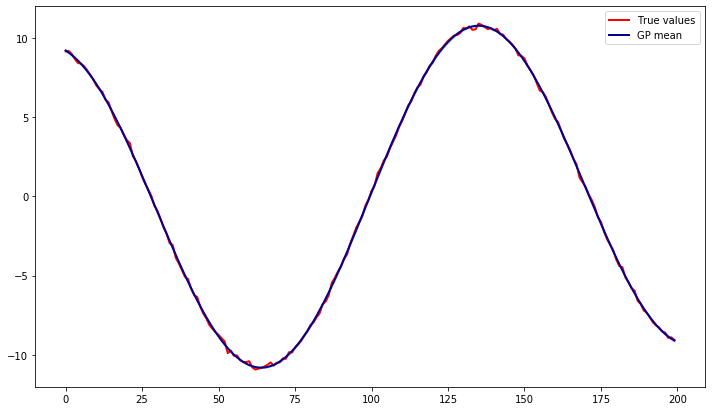

In [23]:
gp_plot(y, mu_train, s_train)

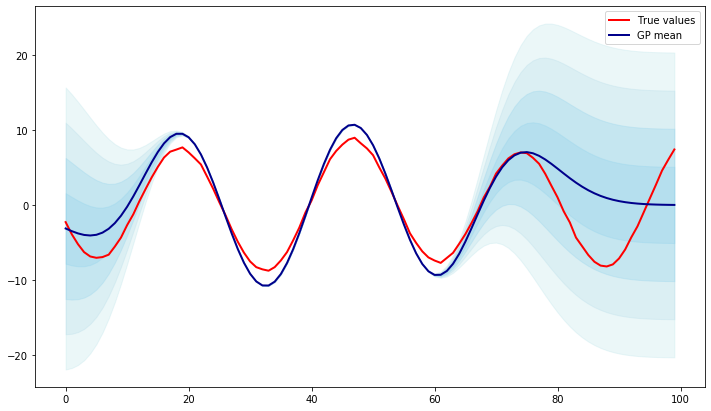

In [24]:
gp_plot(y_test, mu_test, s_test)

### Oil production monitoring using OLGA data

Here we test the algorithm on a synthetic dataset generated by OLGA software - multiphase flow modeling simulator for oil and gas production systems. The used dataset is described in paper (https://id.elsevier.com/as/tCv6T/resume/as/authorization.ping) where we used it for XGBoost evaluation.

In [25]:
data_mat = scipy.io.loadmat('Boosting_data_11.mat') #Oil production data

#Names of the variables contained in the data
names = ['oil_rate_meter', 'gas_rate', 'gas_rate_meter', 
         'choke_opening', 'P_WF', 'T_WF', 'P_WHCU', 
        'T_WHCU', 'P_WHCD', 'T_WHCD', 'P_riser', 'T_riser'
        ]
#Start forming the dataset from the .mat file
data = pd.DataFrame(data_mat['oil_rate_bbl'])
#Append the data into data frame from the MATLAB file
for name in names:
    data = pd.concat([data, pd.DataFrame(data_mat[name])], 
                     axis=1, ignore_index=True)
data = pd.DataFrame(data.values, columns = ['oil_rate_bbl', 'oil_rate_meter', 
                                            'gas_rate', 'gas_rate_meter', 
                                            'choke_opening', 'P_WF', 'T_WF', 
                                            'P_WHCU', 'T_WHCU', 'P_WHCD', 
                                            'T_WHCD', 'P_riser', 'T_riser'])

# Form the features dataset. Drop the target 
# variables and P, T riser (possible to include later 
# to see if it helps to make better predictions)
X_estim_raw = data.drop(columns = ['oil_rate_bbl', 'oil_rate_meter', 
                                   'gas_rate', 'gas_rate_meter',
                                   'P_riser', 'T_riser'
                                  ], 
                        inplace = False)

# Data for multiphase flow meter - flowrate measured by the multiphase flow meter
y_estim_raw = pd.DataFrame(data[['oil_rate_meter']])
y_estim_raw.columns = ['oil_rate_bbl']

from sklearn.preprocessing import StandardScaler
scalerX = StandardScaler().fit(X_estim_raw)
scalery = StandardScaler().fit(y_estim_raw)

X = X_estim_raw[:1300].values
y = y_estim_raw[:1300].values
X_test = X_estim_raw[1300:1800].values
y_test = y_estim_raw[1300:1800].values

X = scalerX.transform(X)
y = scalery.transform(y)
X_test = scalerX.transform(X_test)
y_test = scalery.transform(y_test)

In [26]:
%%time
d = 1
sigma_y = 1.0

k1 = RBF_kernel(dimension=X.shape[1])
gpr = GPRegressor(kernel=k1, sigma_y=sigma_y, optimize_noise=False)

best_params, llh = gpr.fit(X=X, y=y, method="ML")
mu_train, s_train = gpr.predict(parameters=best_params, 
                                X_train=X, X_test=X, 
                                y_train=y, y_test =y, 
                                sigma_y=sigma_y)
mu_test, s_test = gpr.predict(parameters=best_params, 
                              X_train=X, X_test=X_test, 
                              y_train=y, y_test=y_test, 
                              sigma_y=sigma_y)

Wall time: 3min 39s


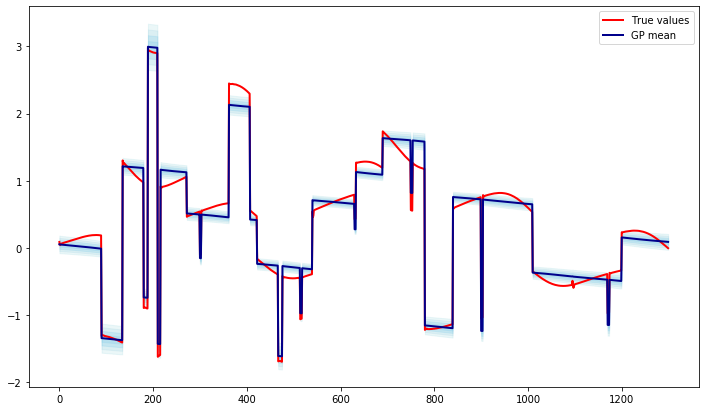

In [27]:
gp_plot(y, mu_train, s_train)

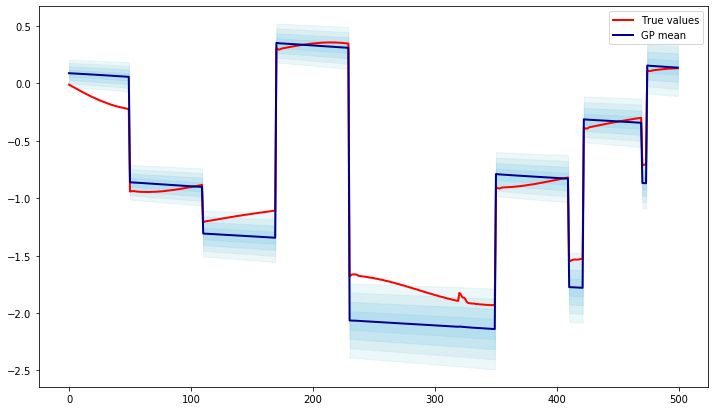

In [28]:
gp_plot(y_test, mu_test, s_test)